# Synopsis

Applying Syuzhet methods to *Persuasion* using NRC, Bing, Syuzhet, and VADER.

# Configuration

In [1]:
pwd = '/Users/rca2t/COURSES/DSI/DS5559/UVA_DSI_REPO/labs/2019-04-11_Lab11/'

# Developed in other notebook
lex_db = './lexicons.db'

# Developed in previous lab
text_db = '../2019-02-21_Lab06/persuasion.db'
# text_db = '../2019-02-21_Lab06/moby.db'
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

# emo = 'bing_sentiment'
emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

# Libraries

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import sys
import scipy.fftpack as fftpack
from sklearn.neighbors import KernelDensity as KDE
from sklearn.preprocessing import scale

import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

# Pragmas

In [3]:
%cd {pwd}
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

/Users/rca2t/Dropbox/Courses/DSI/DS5559/UVA_DSI_REPO/labs/2019-04-11_Lab11


# Process

## Get Lexicons

In [4]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [5]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.75,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.50,NaN
abandoner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-0.25,-1.0
abandons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,NaN


### Get lexicon columns

In [6]:
# emo_cols = [col for col in combo.columns if 'nrc_' in col]
emo_cols = combo.columns

In [7]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'syu_sentiment', 'gi_sentiment'],
      dtype='object')

## Get Text

In [8]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE punc = 0", db, index_col=OHCO)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

### Merge sentiment lexicon with vocab

In [9]:
tokens = tokens.join(combo, on='term_str', how='left')

In [10]:
tokens[emo].sample(10)

chap_num  para_num  sent_num  token_num
16        26        8         5           NaN
17        33        21        46          NaN
5         25        0         25          NaN
20        89        9         34          NaN
18        36        0         20          NaN
17        33        4         3           NaN
10        23        3         47          NaN
21        63        7         4           NaN
11        55        0         0           NaN
6         3         1         9           NaN
Name: syu_sentiment, dtype: float64

In [11]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [12]:
tokens.head(10)

pos      token_str  punc  num  \
chap_num para_num sent_num token_num                                  
0        0        0        0           NN        Chapter     0    0   
                           1           CD              1     0    1   
         1        0        0          NNP            Sir     0    0   
                           1          NNP         Walter     0    0   
                           2          NNP         Elliot     0    0   
                           4           IN             of     0    0   
                           5          NNP       Kellynch     0    0   
                           6          NNP           Hall     0    0   
                           8           IN             in     0    0   
                           9          NNP  Somersetshire     0    0   

                                           term_str  term_id  nrc_anger  \
chap_num para_num sent_num token_num                                      
0        0        0        0                chapter      800        0.0   
                           1                   None       -1        0.0   
         1        0        0                    sir     4658        0.0   
                           1                 walter     5534        0.0   
                           2                 elliot     1635        0.0   
                           4                     of     3442        0.0   
                           5               kellynch     2854        0.0   
                           6                   hall     2342        0.0   
                           8                     in     2605        0.0   
                           9          somersetshire     4734        0.0   

                                      nrc_anticipation  nrc_disgust  nrc_fear  \
chap_num para_num sent_num token_num                                            
0        0        0        0                       0.0          0.0       0.0   
                           1                       0.0          0.0       0.0   
         1        0        0                       0.0          0.0       0.0   
                           1                       0.0          0.0       0.0   
                           2                       0.0          0.0       0.0   
                           4                       0.0          0.0       0.0   
                           5                       0.0          0.0       0.0   
                           6                       0.0          0.0       0.0   
                           8                       0.0          0.0       0.0   
                           9                       0.0          0.0       0.0   

                                          ...       nrc_negative  \
chap_num para_num sent_num token_num      ...                      
0        0        0        0              ...                0.0   
                           1              ...                0.0   
         1        0        0              ...                0.0   
                           1              ...                0.0   
                           2              ...                0.0   
                           4              ...                0.0   
                           5              ...                0.0   
                           6              ...                0.0   
                           8              ...                0.0   
                           9              ...                0.0   

                                      nrc_positive  nrc_sadness  nrc_surprise  \
chap_num para_num sent_num token_num                                            
0        0        0        0                   0.0          0.0           0.0   
                           1                   0.0          0.0           0.0   
         1        0        0                   1.0          0.0           0.0   
                           1                   0.0          0.0           0.0   
        

## Sentiment by OHCO

In [13]:
FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)

### By Chapter

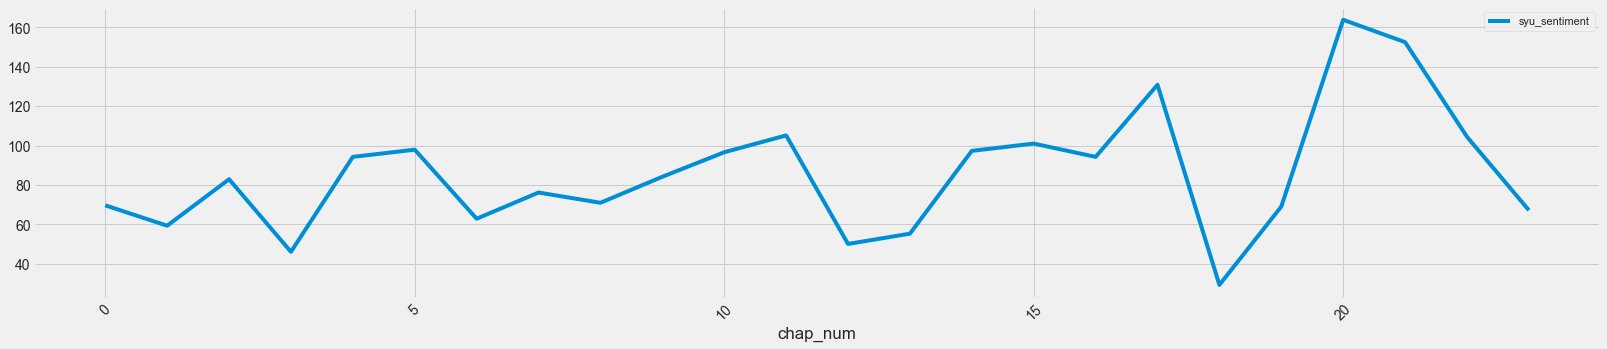

In [14]:
tokens.groupby(CHAPS)[emo].sum().plot(**FIG)

### By Paragraph

In [15]:
by_para = tokens.groupby(PARAS)[emo_cols].sum()

In [16]:
max_x = by_para.shape[0]
xticks = list(range(0, max_x, 100))
xticks.append(max_x - 1)

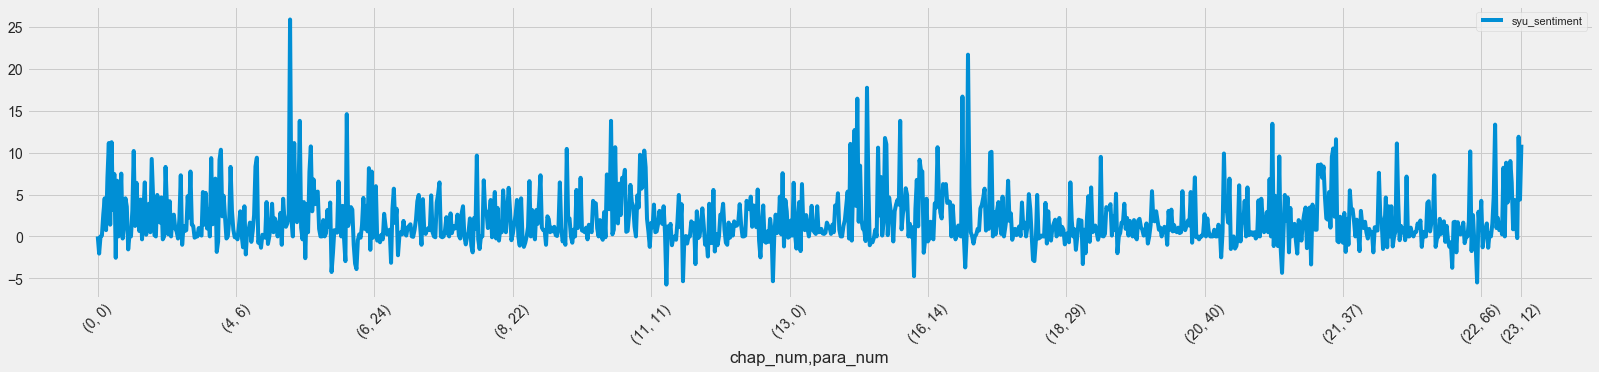

In [17]:
by_para[emo].plot(**FIG, xticks=xticks)

### By Sentence

In [18]:
by_sent = tokens.groupby(SENTS)[emo_cols].sum()

In [19]:
max_x = by_sent.shape[0]
xticks = list(range(0, max_x, 250))
xticks.append(max_x - 1)

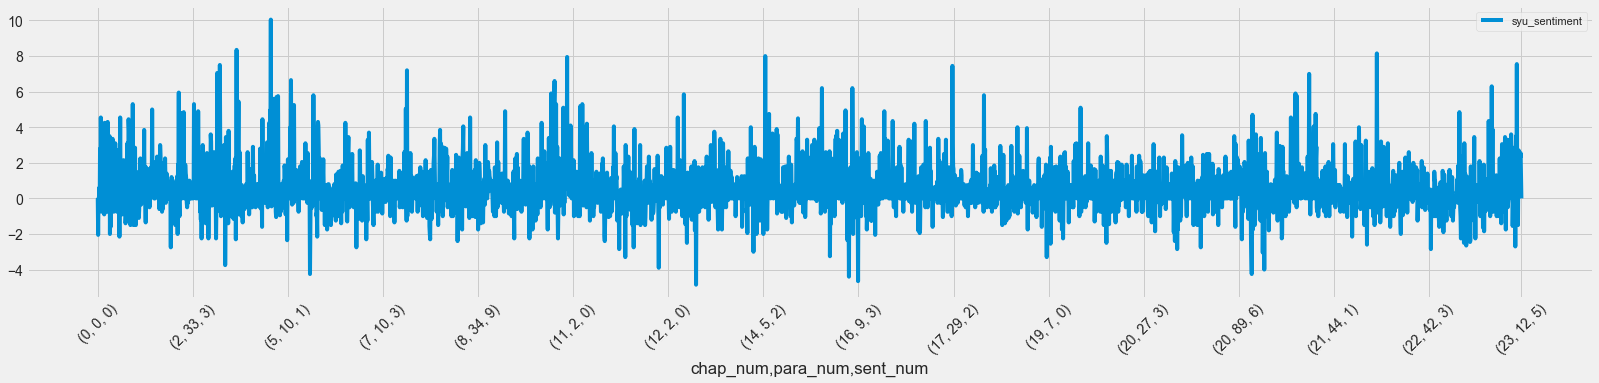

In [20]:
by_sent[emo].plot(**FIG, xticks=xticks)

### Add text to do spot checks

In [21]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [22]:
tokens['html'].head()

chap_num  para_num  sent_num  token_num
0         0         0         0            <span class='sent0'>Chapter</span>
                              1                  <span class='sent0'>1</span>
          1         0         0                <span class='sent1'>Sir</span>
                              1             <span class='sent0'>Walter</span>
                              2             <span class='sent0'>Elliot</span>
Name: html, dtype: object

In [23]:
by_sent['sent_str'] = tokens.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_sent['html_str'] = tokens.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))

In [24]:
by_sent[['sent_str', 'html_str']].head()

sent_str  \
chap_num para_num sent_num                                                      
0        0        0                                                   chapter   
         1        0         sir walter elliot of kellynch hall in somerset...   
                  1         this was the page at which the favourite volum...   
         2        0                                   elliot of kellynch hall   
         3        0         walter elliot born march married july elizabet...   

                                                                     html_str  
chap_num para_num sent_num                                                     
0        0        0         <span class='sent0'>Chapter</span> <span class...  
         1        0         <span class='sent1'>Sir</span> <span class='se...  
                  1         <span class='sent0'>This</span> <span class='s...  
         2        0         <span class='sent0'>ELLIOT</span> <span class=...  
         3        0         <span class='sent0'>Walter</span> <span class=...

### Histogram

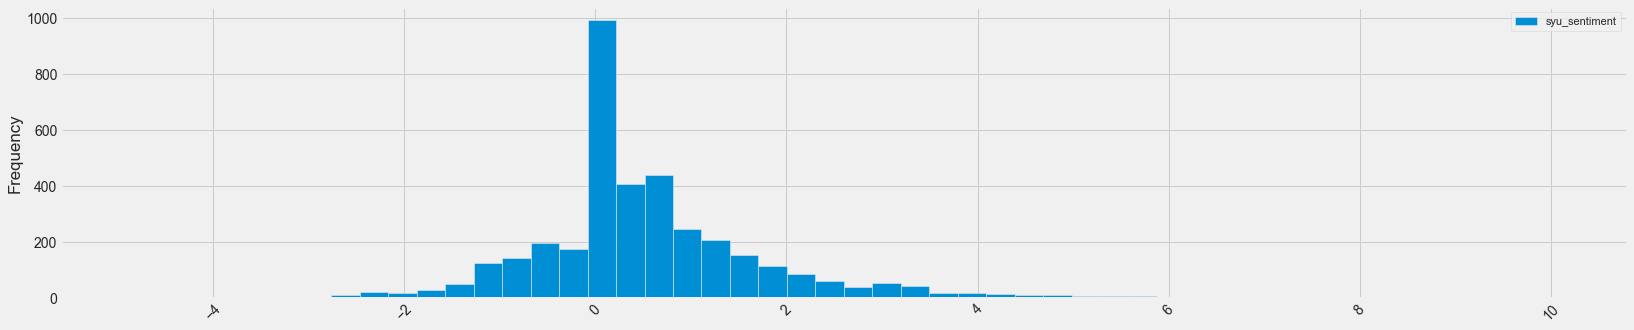

In [25]:
by_sent[emo].plot.hist(**FIG, bins=50)

### Look at a sample of sentences

In [26]:
rows = []
for idx in by_sent.sample(10).index:
    
    valence = round(by_sent.loc[idx, emo], 4)     
    t = 0
    if valence > t: color = '#ccffcc'
    elif valence < t: color = '#ffcccc'
    else: color = '#f2f2f2'
    z=0
    rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
    <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
    </tr>""".format(color, valence, by_sent.loc[idx, 'html_str'], idx))
    
display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

Sentiment,ID,Sentence
1.0,"(7, 41, 0)",Depend upon it they were all perfectly comfortable
0.4,"(13, 35, 1)",Mr Elliot was in Bath
3.0,"(2, 7, 0)",They would look around them no doubt and bless their good fortune said Mrs Clay for Mrs Clay was present her father had driven her over nothing being of so much use to Mrs Clay s health as a drive to Kellynch but I quite agree with my father in thinking a sailor might be a very desirable tenant
0.0,"(12, 28, 2)",We told you about the laundry door at Uppercross
1.3,"(12, 13, 0)",Lady Russell had only to listen composedly and wish them happy but internally her heart revelled in angry pleasure in pleased contempt that the man who at twenty three had seemed to understand somewhat of the value of an Anne Elliot should eight years afterwards be charmed by a Louisa Musgrove
0.05,"(5, 10, 2)",Nobody doubts her right to have precedence of mamma but it would be more becoming in her not to be always insisting on it
2.8,"(4, 38, 0)",I am very glad you were well enough and I hope you had a pleasant party
0.0,"(20, 101, 1)",It was just possible that she might have been persuaded by Lady Russell
0.0,"(20, 30, 3)",Till it does come you know we women never mean to have anybody
0.5,"(11, 70, 1)",He had handed them both in and placed himself between them and in this manner under these circumstances full of astonishment and emotion to Anne she quitted Lyme


### Plot with Xticks

In [27]:
xticks = [0]
xticks += by_sent[emo].reset_index().sort_values(emo).head(7).index.values.tolist()
xticks += by_sent[emo].reset_index().sort_values(emo).tail(7).index.values.tolist()
xticks += [by_sent.shape[0] - 1]

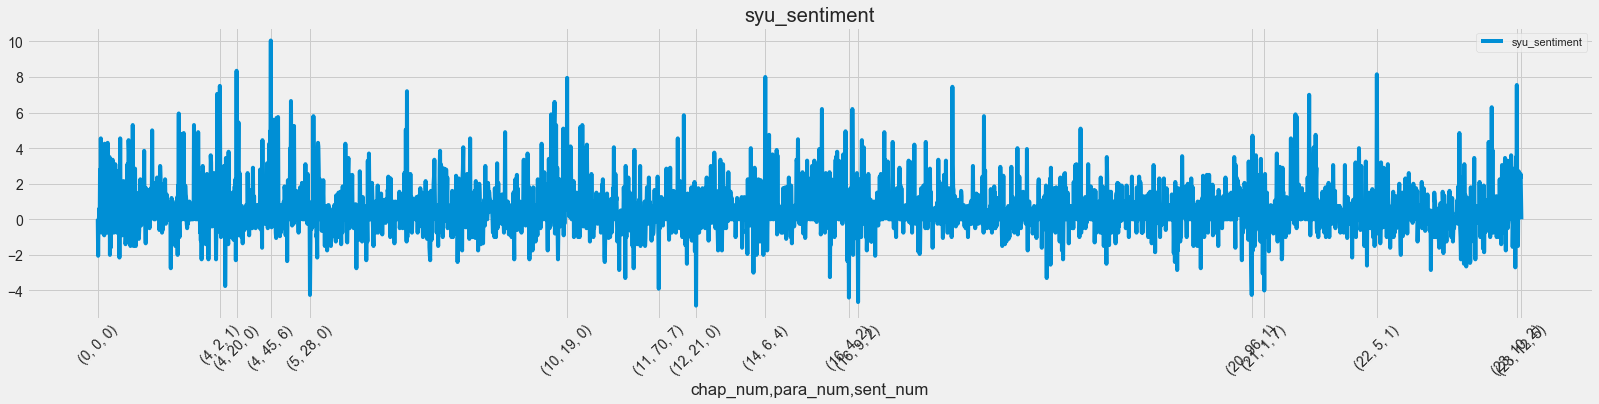

In [28]:
by_sent[emo].plot(**FIG, xticks=xticks, title=emo)

In [29]:
by_sent.iloc[xticks][emo].sort_index().to_frame()

syu_sentiment
chap_num para_num sent_num               
0        0        0          0.000000e+00
4        2        1          7.500000e+00
         20       0          8.350000e+00
         45       6          1.005000e+01
5        28       0         -4.250000e+00
10       19       0          7.950000e+00
11       70       7         -3.900000e+00
12       21       0         -4.850000e+00
14       6        4          8.000000e+00
16       4        2         -4.400000e+00
         9        2         -4.650000e+00
20       96       1         -4.250000e+00
21       1        7         -4.000000e+00
22       5        1          8.150000e+00
23       10       2          7.550000e+00
         12       5         -1.110223e-16

### Inspect Positives

In [30]:
by_sent.sort_values(emo, ascending=False)[[emo,'sent_str']].head(20)

syu_sentiment  \
chap_num para_num sent_num                  
4        45       6                 10.05   
         20       0                  8.35   
22       5        1                  8.15   
14       6        4                  8.00   
10       19       0                  7.95   
23       10       2                  7.55   
4        2        1                  7.50   
17       28       6                  7.45   
7        29       2                  7.20   
3        10       3                  7.05   
21       29       1                  7.00   
5        13       0                  6.65   
10       9        3                  6.60   
22       76       7                  6.30   
15       7        1                  6.20   
16       6        3                  6.20   
2        18       1                  5.95   
21       21       1                  5.90   
10       6        3                  5.90   
12       10       2                  5.85   

                                                                     sent_str  
chap_num para_num sent_num                                                     
4        45       6         anne always contemplated them as some of the h...  
         20       0         uppercross was a moderate sized village which ...  
22       5        1         anne felt that she did not belong to the conve...  
14       6        4         he had been in bath about a fortnight he had p...  
10       19       0         anne thought she left great happiness behind h...  
23       10       2         the disproportion in their fortune was nothing...  
4        2        1         each lady was previously well disposed for an ...  
17       28       6         she always watched them as long as she could d...  
7        29       2         mrs musgrove was of a comfortable substantial ...  
3        10       3         she could do justice to the superiority of lad...  
21       29       1         mary was in excellent spirits enjoying the gai...  
5        13       0         she played a great deal better than either of ...  
10       9        3         the scenes in its neighbourhood charmouth with...  
22       76       7         with the musgroves there was the happy chat of...  
15       7        1         in lady russell s view it was perfectly natura...  
16       6        3         twelve years had changed anne from the bloomin...  
2        18       1         by the report which he hastened over to kellyn...  
21       21       1         she had imagined such difficulties of fortune ...  
10       6        3         his acquittal was complete his friendship warm...  
12       10       2         but happily either anne was improved in plumpn...

### Inspect Negatives

In [31]:
by_sent.sort_values(emo, ascending=True)[[emo,'sent_str']].head(20)

syu_sentiment  \
chap_num para_num sent_num                  
12       21       0                 -4.85   
16       9        2                 -4.65   
         4        2                 -4.40   
20       96       1                 -4.25   
5        28       0                 -4.25   
21       1        7                 -4.00   
11       70       7                 -3.90   
4        11       1                 -3.75   
20       96       0                 -3.40   
19       4        1                 -3.30   
11       43       0                 -3.30   
15       12       0                 -3.25   
21       1        3                 -3.05   
13       35       3                 -3.00   
11       34       3                 -2.85   
22       42       8                 -2.85   
20       52       9                 -2.85   
2        16       3                 -2.75   
6        28       2                 -2.75   
20       63       6                 -2.75   

                                                                     sent_str  
chap_num para_num sent_num                                                     
12       21       0         as to the sad catastrophe itself it could be c...  
16       9        2         then she had indeed been a pitiable object for...  
         4        2         she had had difficulties of every sort to cont...  
20       96       1         it was a dreadful picture of ingratitude and i...  
5        28       0         the real circumstances of this pathetic piece ...  
21       1        7         she was concerned for the disappointment and p...  
11       70       7         once only when she had been grieving over the ...  
4        11       1         lady russell was extremely sorry that such a m...  
20       96       0         anne was shewn some letters of his on the occa...  
19       4        1         i am afraid you must have suffered from the sh...  
11       43       0         as to the wretched party left behind it could ...  
15       12       0         sir walter had once been in company with the l...  
21       1        3         he stood as opposed to captain wentworth in al...  
13       35       3         if elizabeth and her father did not deceive th...  
11       34       3         screamed mary catching hold of her husband and...  
22       42       8         unjust i may have been weak and resentful i ha...  
20       52       9         mr elliot is a man without heart or conscience...  
2        16       3         a man is in greater danger in the navy of bein...  
6        28       2         how absurd to be resuming the agitation which ...  
20       63       6         i think differently now time and sickness and ...

## Apply Transforms

### Adapt Jockers' original FFT function 

Fast Fourier Transform. See https://rdrr.io/cran/syuzhet/man/get_transformed_values.html

In [124]:
def get_transformed_values(raw_values, low_pass_size = 2, x_reverse_len = 100,  padding_factor = 2, scale_values = False, scale_range = False):

    if low_pass_size > len(raw_values):
        sys.exit("low_pass_size must be less than or equal to the length of raw_values input vector")

    raw_values_len = len(raw_values)
    padding_len = raw_values_len * padding_factor

    # Add padding, then fft
    values_fft = fftpack.fft(raw_values, padding_len)
    low_pass_size = low_pass_size * (1 + padding_factor)
    keepers = values_fft[:low_pass_size]

    # Preserve frequency domain structure
    modified_spectrum = list(keepers) \
        + list(np.zeros((x_reverse_len * (1+padding_factor)) - (2*low_pass_size) + 1)) \
        + list(reversed(np.conj(keepers[1:(len(keepers))])))
    
    
    # Strip padding
    inverse_values = fftpack.ifft(modified_spectrum)
    inverse_values = inverse_values[:x_reverse_len]

#     transformed_values = np.real(tuple(inverse_values))
    transformed_values = np.real(inverse_values)
    return transformed_values

In [125]:
FFTCFG = dict(
    low_pass_size = 3,
    x_reverse_len = 100,
    padding_factor = 2
)
X = get_transformed_values(by_sent[emo].values, **FFTCFG)

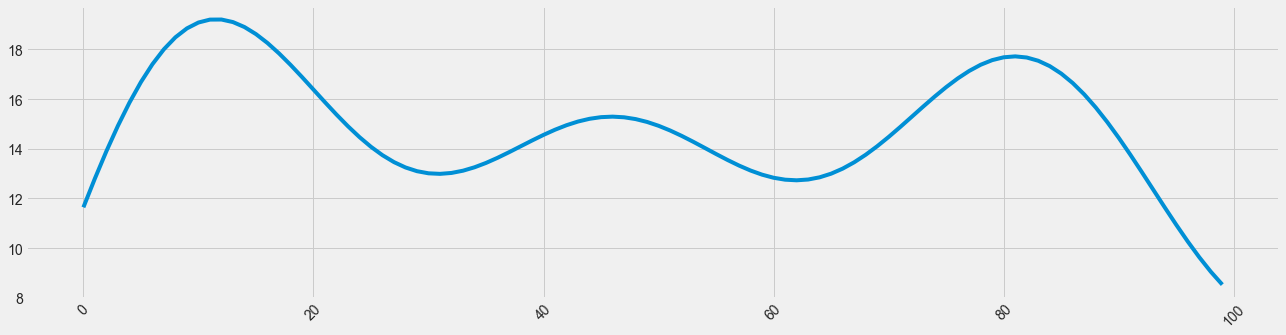

In [126]:
FIG['legend'] = False
pd.Series(X).plot(**FIG)

### Adapt Jockers' revised DCT function

Discrete Cosine Transform. A DCT is a Fourier-related transform similar to the discrete Fourier transform (DFT), but using only real numbers. 

In [35]:
def get_dct_transform(raw_values, low_pass_size = 5, x_reverse_len = 100):
    if low_pass_size > len(raw_values):
        raise ValueError("low_pass_size must be less than or equal to the length of raw_values input vector")
    values_dct = fftpack.dct(raw_values, type = 2)
    keepers = values_dct[:low_pass_size]
    padded_keepers = list(keepers) + list(np.zeros(x_reverse_len - low_pass_size))
    dct_out = fftpack.idct(padded_keepers)
    return(dct_out)

In [36]:
FFTCFG1 = dict(
    low_pass_size = 5,
    x_reverse_len = 100
)
X1 = get_dct_transform(by_sent[emo].values, **FFTCFG1)

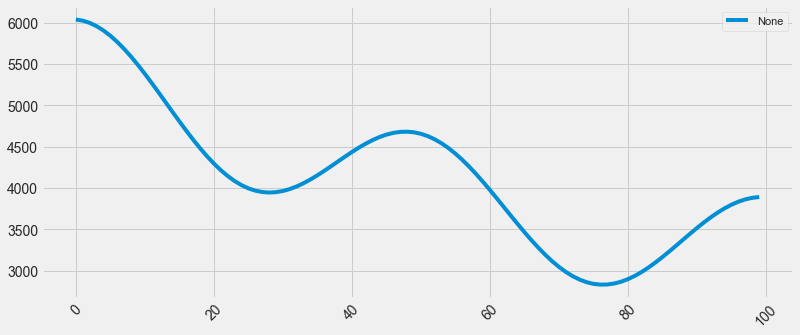

In [82]:
FIG['figsize'] = (12,5)
pd.Series(X1).plot(**FIG)

<img src="pers_rplot.jpg" width="900"/>

### Using Rolling
**Window types**: 
boxcar
triang
blackman
hamming
bartlett
parzen
bohman
blackmanharris
nuttall
barthann
kaiser (needs beta)
gaussian (needs std)
general_gaussian (needs power, width)
slepian (needs width).

In [85]:
# Config for sentences
CFG1 = dict(
    win_type='triang',
    window=1000,
    center=True
)

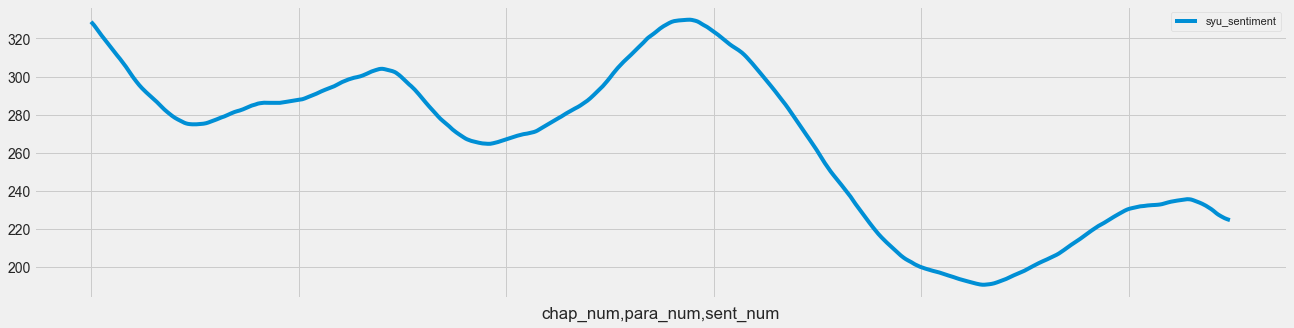

In [86]:
FIG['figsize'] = (20,5)
by_sent[emo].fillna(0).rolling(**CFG1).sum().plot(**FIG)

In [87]:
# Config for tokens
CFG2 = dict(
    win_type='triang',
    window= int(tokens.shape[0]/ 9),
    center=True
)
CFG2['window']

9355

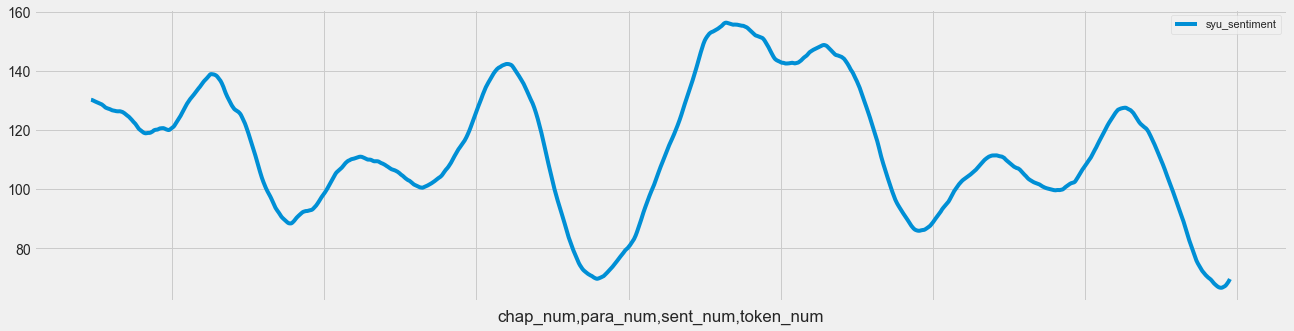

In [88]:
tokens[emo].fillna(0).rolling(**CFG2).sum().plot(**FIG)

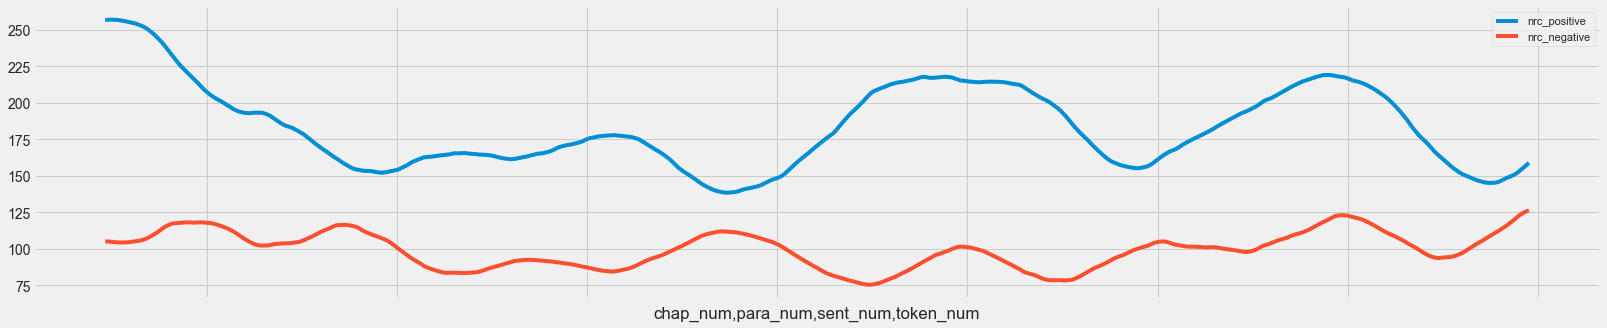

In [43]:
tokens[['nrc_positive','nrc_negative']].rolling(**CFG2).sum().plot(**FIG)

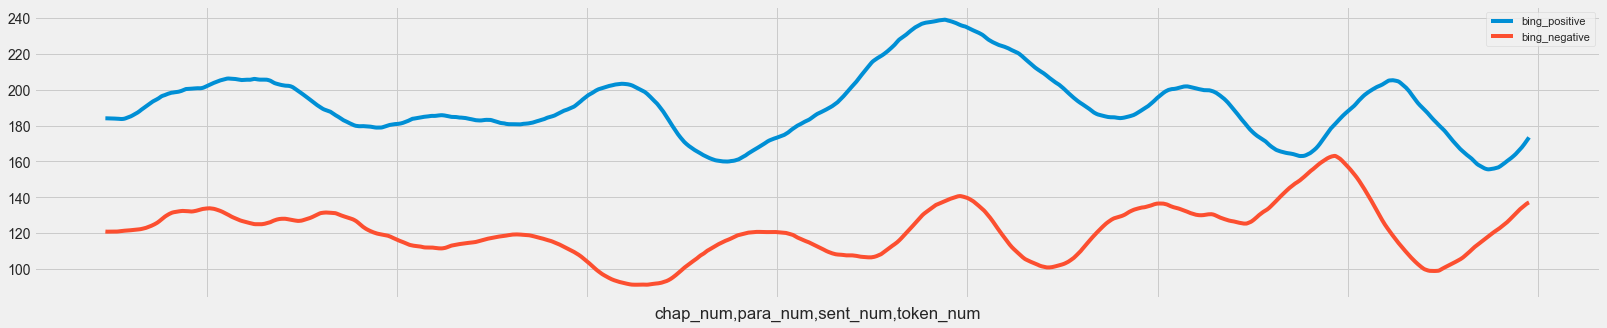

In [44]:
tokens[['bing_positive','bing_negative']].fillna(0).rolling(**CFG2).sum().plot(**FIG)

## Multinomial Emotions

In [45]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [89]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.25,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


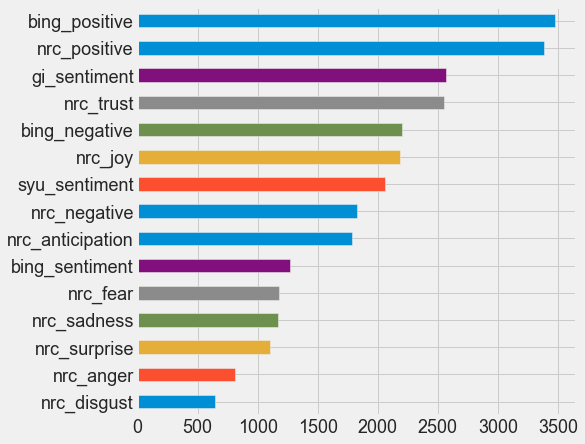

In [47]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18)

### Shape data for Sklearn's KDE function

In [48]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [49]:
B

,x
emo,
nrc_anger,"[[52], [71], [78], [91], [203], [381], [572], ..."
nrc_anticipation,"[[48], [210], [381], [415], [426], [434], [454..."
nrc_disgust,"[[71], [91], [412], [572], [593], [601], [704]..."
nrc_fear,"[[38], [71], [78], [91], [210], [381], [528], ..."
nrc_joy,"[[17], [28], [46], [48], [78], [130], [210], [..."
nrc_negative,"[[38], [52], [60], [71], [78], [91], [203], [2..."
nrc_positive,"[[2], [17], [28], [46], [48], [78], [130], [18..."
nrc_sadness,"[[52], [60], [78], [91], [244], [430], [572], ..."
nrc_surprise,"[[381], [415], [458], [528], [664], [683], [70..."


### Get KDE for each emotion

In [50]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
# kde_bandwidth = 250
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

### Visualize KDE plots

In [51]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T

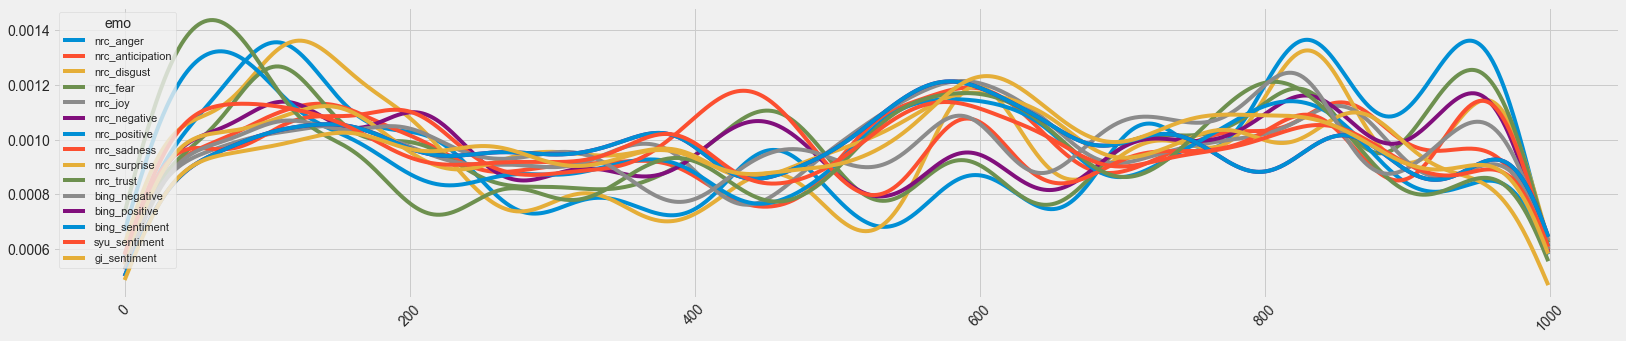

In [52]:
PLOTS.plot(**FIG)

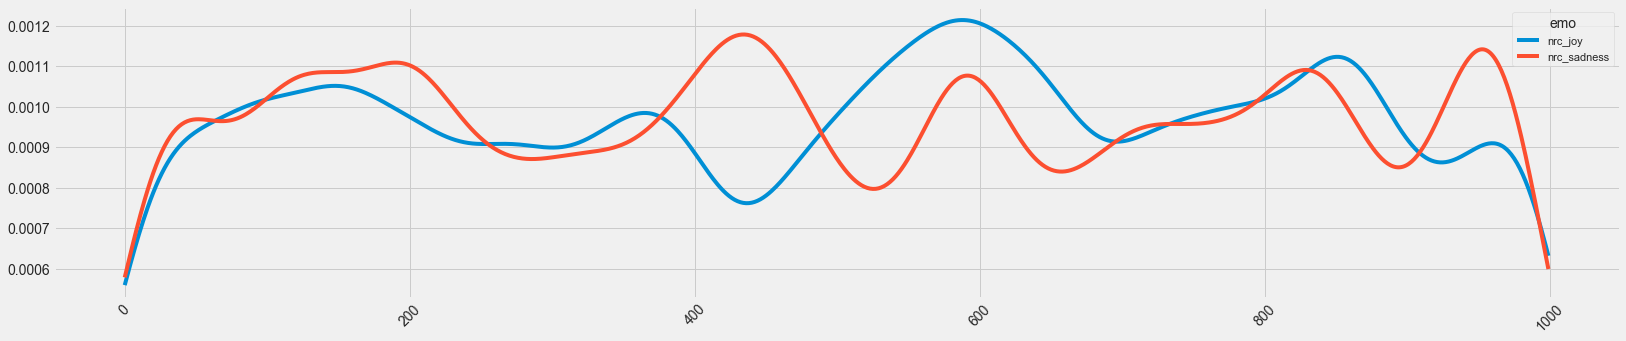

In [53]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

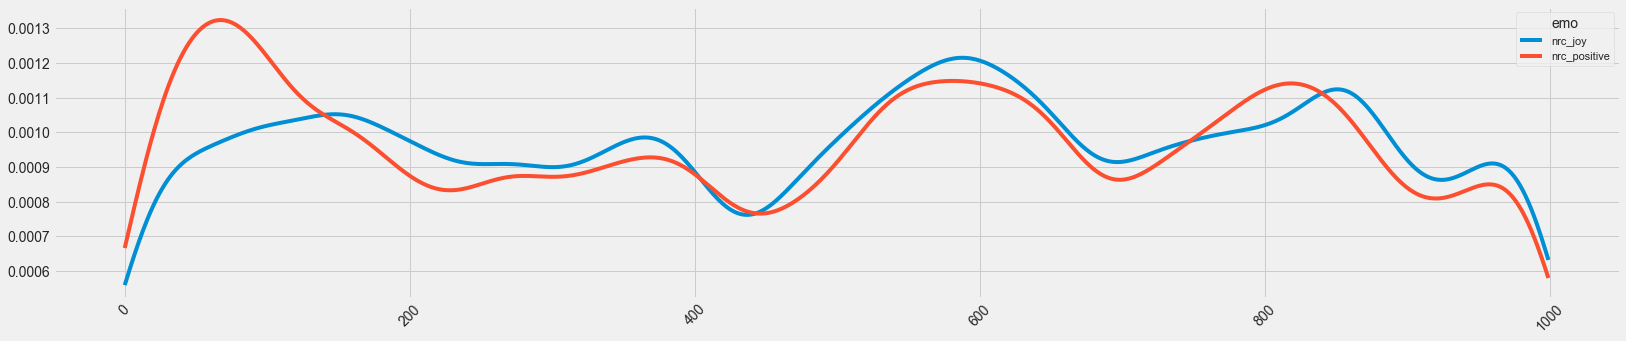

In [54]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)

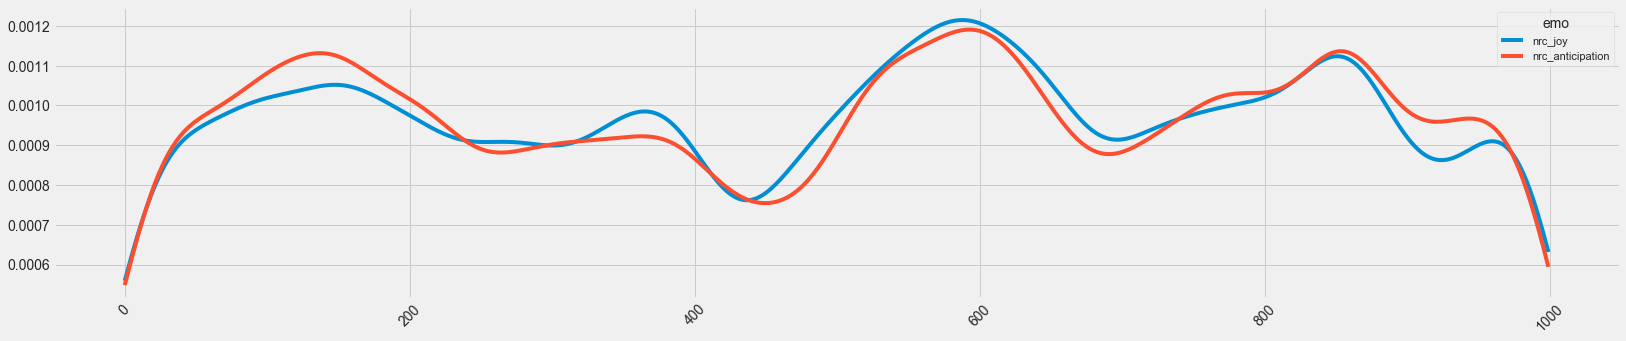

In [55]:
PLOTS[['nrc_joy','nrc_anticipation']].plot(**FIG)

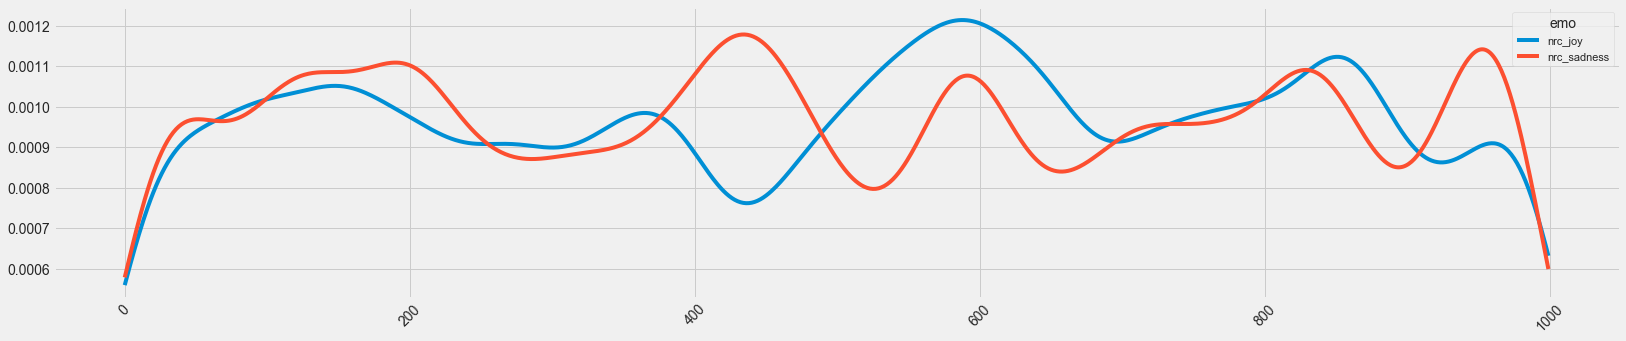

In [56]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

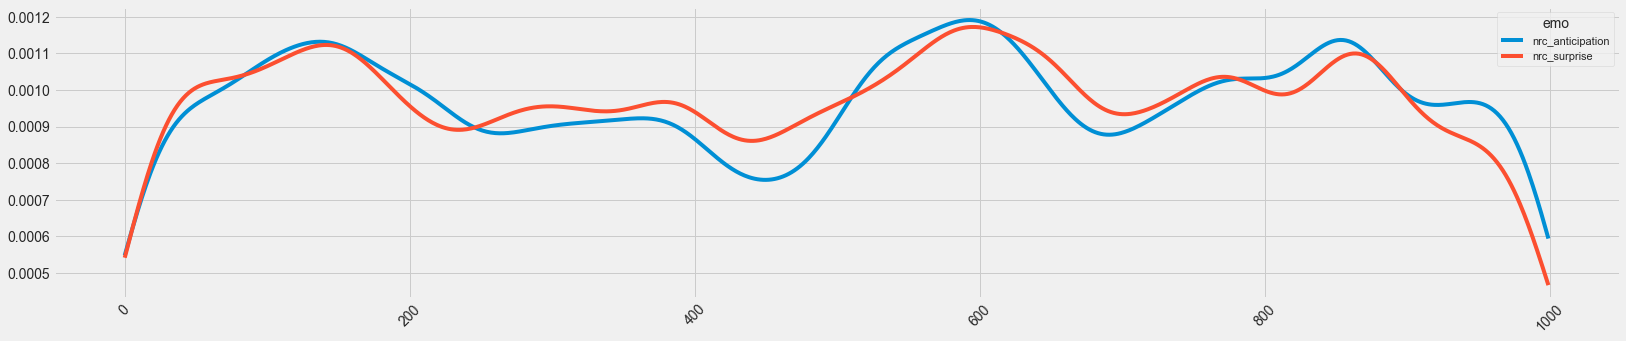

In [57]:
PLOTS[['nrc_anticipation','nrc_surprise']].plot(**FIG)

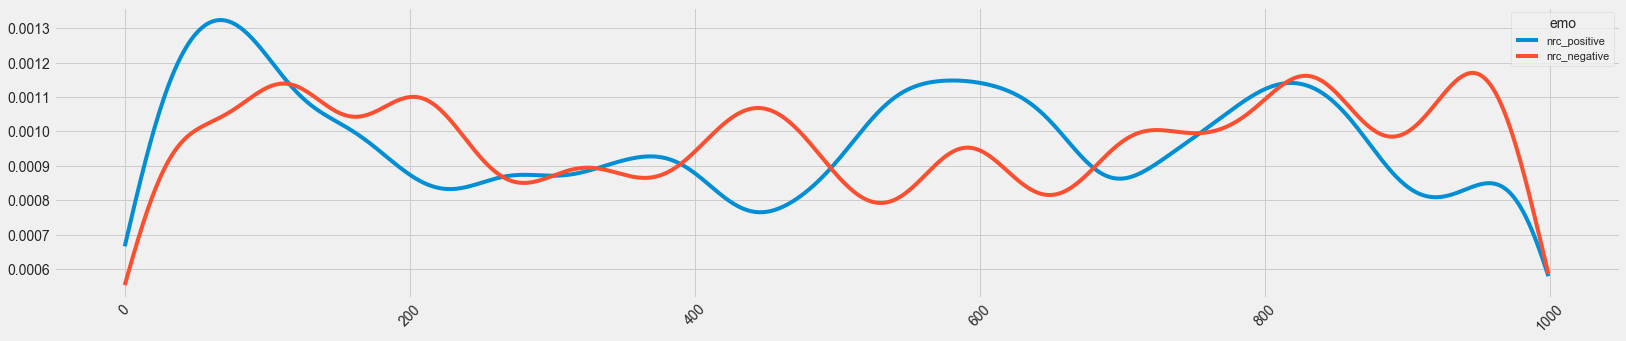

In [58]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)

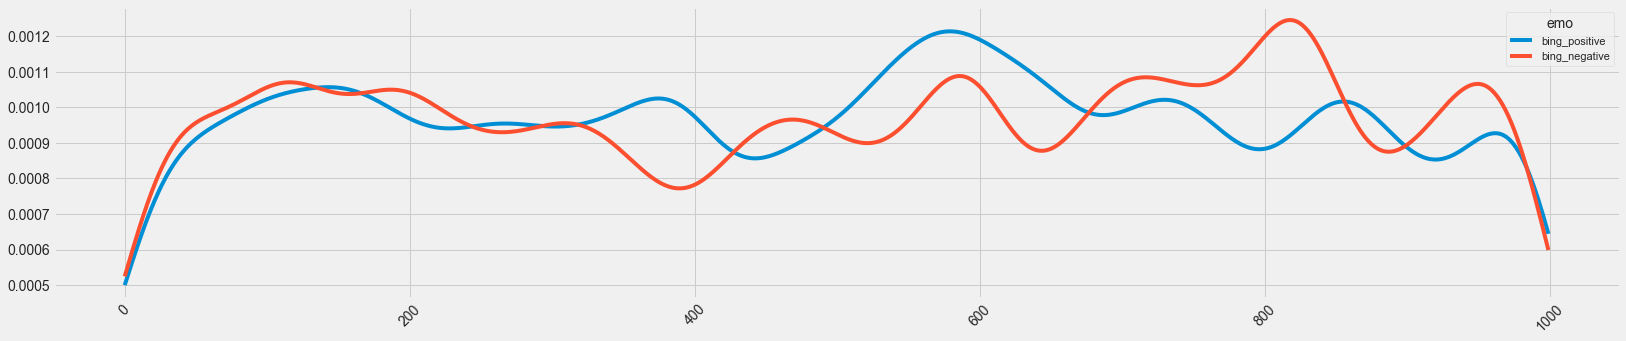

In [59]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)

### Compare KDE to Rolling graphs of Sentiment

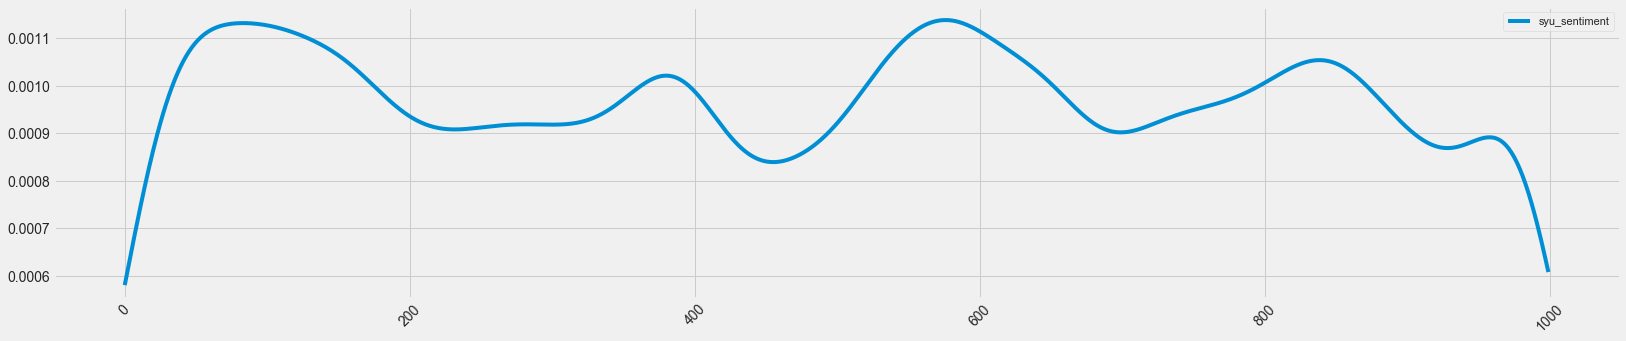

In [64]:
PLOTS[emo].plot(**FIG)

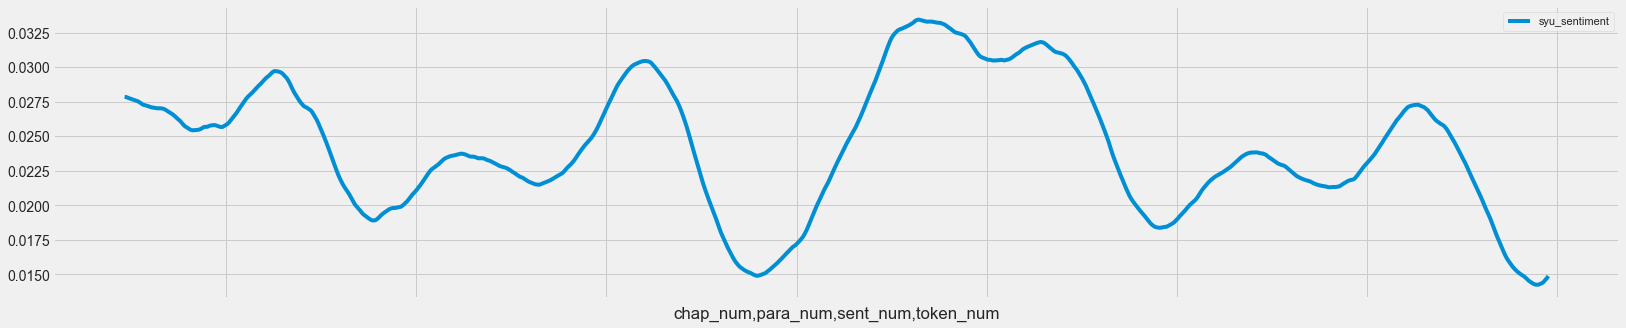

In [63]:
tokens[emo].fillna(0).rolling(**CFG2).mean().plot(**FIG)

In [ ]:
fig, axs = plt.subplots(len(emo_cols),2)
for i, emo in enumerate(emo_cols):
    FIGa = dict(figsize=(20,50), ax=axs[i,0], title=emo + ' (KDE)')
    FIGb = dict(figsize=(20,50), ax=axs[i,1], title=emo + ' (rolling)')
    PLOTS[emo].plot(**FIGa)
    tokens[emo].rolling(**CFG2).mean().plot(**FIGb)

## Peak Joy

### Find max joy from PLOTS

In [65]:
PLOTS.head()

emo,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.000569,0.000548,0.000618,0.000556,0.000559,0.000554,0.000666,0.000578,0.000542,0.000733,0.000524,0.000500,0.000500,0.000580,0.000486
1,0.000583,0.000562,0.000634,0.000570,0.000572,0.000568,0.000684,0.000593,0.000557,0.000753,0.000538,0.000513,0.000513,0.000596,0.000499
2,0.000598,0.000576,0.000650,0.000584,0.000586,0.000583,0.000702,0.000608,0.000572,0.000773,0.000552,0.000525,0.000525,0.000611,0.000512
3,0.000612,0.000590,0.000666,0.000597,0.000599,0.000597,0.000719,0.000622,0.000587,0.000792,0.000565,0.000538,0.000538,0.000626,0.000525
4,0.000626,0.000603,0.000682,0.000611,0.000612,0.000612,0.000737,0.000637,0.000602,0.000812,0.000579,0.000550,0.000550,0.000642,0.000538


In [66]:
PEAK_JOY = int((PLOTS['nrc_joy'].idxmax() / 1000) * tokens.shape[0])

In [67]:
PEAK_JOY_CHAP_NUM = tokens.iloc[PEAK_JOY].name[0]

In [68]:
PEAK_JOY_CHAP_NUM + 1

17

### Display Chapter

In [69]:
PEAK_JOY_CHAP = tokens.loc[PEAK_JOY_CHAP_NUM].groupby(['para_num']).token_str.apply(lambda x: ' '.join(x)).tolist()

In [70]:
display(HTML('<br/><br/>'.join(PEAK_JOY_CHAP)))

### Sparknotes' Synopsis

> One night, the Elliots receive an invitation to the Dalrymples' place, and Anne tells her family she must decline it because she has an engagement to visit Mrs. Smith. Sir Walter is horrified that Anne should be visiting such a poor neighborhood and is appalled that she chooses to associate with someone so much lower in consequence than herself.

https://www.sparknotes.com/lit/persuasion/section9/

## VADER

In [71]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [72]:
vader_cols = by_sent.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))

In [73]:
by_sent = pd.concat([by_sent, vader_cols], axis=1)

In [74]:
by_sent.head()

nrc_anger  nrc_anticipation  nrc_disgust  \
chap_num para_num sent_num                                             
0        0        0               0.0               0.0          0.0   
         1        0               4.0               1.0          2.0   
                  1               0.0               0.0          0.0   
         2        0               0.0               0.0          0.0   
         3        0               0.0               0.0          0.0   

                            nrc_fear  nrc_joy  nrc_negative  nrc_positive  \
chap_num para_num sent_num                                                  
0        0        0              0.0      0.0           0.0           0.0   
         1        0              4.0      5.0           6.0           6.0   
                  1              0.0      0.0           0.0           0.0   
         2        0              0.0      0.0           0.0           0.0   
         3        0              0.0      1.0           0.0           1.0   

                            nrc_sadness  nrc_surprise  nrc_trust    ...     \
chap_num para_num sent_num                                          ...      
0        0        0                 0.0           0.0        0.0    ...      
         1        0                 4.0           0.0        5.0    ...      
                  1                 0.0           0.0        0.0    ...      
         2        0                 0.0           0.0        0.0    ...      
         3        0                 0.0           0.0        0.0    ...      

                            bing_positive  bing_sentiment  syu_sentiment  \
chap_num para_num sent_num                                                 
0        0        0                   0.0             0.0           0.00   
         1        0                   3.0            -5.0          -2.05   
                  1                   0.0             0.0           0.00   
         2        0                   0.0             0.0           0.00   
         3        0                   0.0             0.0           0.60   

                            gi_sentiment  \
chap_num para_num sent_num                 
0        0        0                  0.0   
         1        0                  2.0   
                  1                  0.0   
         2        0                  0.0   
         3        0                  0.0   

                                                                     sent_str  \
chap_num para_num sent_num                                                      
0        0        0                                                   chapter   
         1        0         sir walter elliot of kellynch hall in somerset...   
                  1         this was the page at which the favourite volum...   
         2        0                                   elliot of kellynch hall   
         3        0         walter elliot born march married july elizabet...   

                                                                     html_str  \
chap_num para_num sent_num                                                      
0        0        0         <span class='sent0'>Chapter</span> <span class...   
         1        0         <span class='sent1'>Sir</span> <span class='se...   
                  1         <span class='sent0'>This</span> <span class='s...   
         2        0         <span class='sent0'>ELLIOT</span> <span class=...   
         3        0         <span class='sent0'>Walter</span> <span class=...   

                              neg    neu    pos  compound  
chap_num para_num sent_num                                 
0        0        0         0.000  1.000  0.000    0.0000  
         1        0         0.167  0.671  0.162   -0.1814  
                  1         0.000  1.000  0.000    0.0000  
         2        0         0.000  1.000  0.000    0.0000  
         3        0         0.000  1.000  0.000    0.0000  

[5 rows x 21 columns]

In [90]:
# See "anne could not help laughing"
by_sent.sort_values('neg', ascending=False).head(10)

nrc_anger  nrc_anticipation  nrc_disgust  \
chap_num para_num sent_num                                             
6        29       0               0.0               0.0          0.0   
22       74       0               0.0               0.0          0.0   
21       57       1               0.0               0.0          0.0   
20       39       0               0.0               0.0          0.0   
18       25       1               0.0               0.0          0.0   
20       81       0               0.0               0.0          0.0   
19       50       0               0.0               0.0          0.0   
         29       1               0.0               0.0          1.0   
21       4        2               0.0               0.0          0.0   
19       29       0               0.0               0.0          1.0   

                            nrc_fear  nrc_joy  nrc_negative  nrc_positive  \
chap_num para_num sent_num                                                  
6        29       0              0.0      0.0           0.0           0.0   
22       74       0              0.0      0.0           0.0           0.0   
21       57       1              0.0      0.0           0.0           0.0   
20       39       0              0.0      0.0           0.0           0.0   
18       25       1              0.0      0.0           0.0           0.0   
20       81       0              0.0      0.0           0.0           0.0   
19       50       0              0.0      0.0           0.0           0.0   
         29       1              1.0      0.0           1.0           0.0   
21       4        2              0.0      0.0           0.0           0.0   
19       29       0              1.0      0.0           1.0           0.0   

                            nrc_sadness  nrc_surprise  nrc_trust    ...     \
chap_num para_num sent_num                                          ...      
6        29       0                 0.0           0.0        0.0    ...      
22       74       0                 0.0           0.0        0.0    ...      
21       57       1                 0.0           0.0        0.0    ...      
20       39       0                 0.0           0.0        0.0    ...      
18       25       1                 0.0           0.0        0.0    ...      
20       81       0                 0.0           0.0        0.0    ...      
19       50       0                 0.0           0.0        0.0    ...      
         29       1                 1.0           0.0        0.0    ...      
21       4        2                 0.0           0.0        0.0    ...      
19       29       0                 1.0           0.0        0.0    ...      

                            bing_positive  bing_sentiment  syu_sentiment  \
chap_num para_num sent_num                                                 
6        29       0                   0.0             0.0          -0.40   
22       74       0                   0.0             0.0           0.00   
21       57       1                   0.0             0.0           0.00   
20       39       0                   0.0             0.0           0.00   
18       25       1                   0.0             0.0          -0.40   
20       81       0                   0.0             0.0           0.00   
19       50       0                   0.0             0.0           0.00   
         29       1                   0.0            -1.0          -0.75   
21       4        2                   0.0            -1.0          -0.50   
19       29       0                   0.0            -1.0          -0.75   

                            gi_sentiment   sent_str  \
chap_num para_num sent_num                            
6        29       0                 -1.0       alas   
22       74       0                  0.0      no no   
21       57       1                  0.0         no   
20       39       0                  0.0         no   
18       25       1                 -1.0       alas   
20 

In [76]:
CFG1['window'] = 500

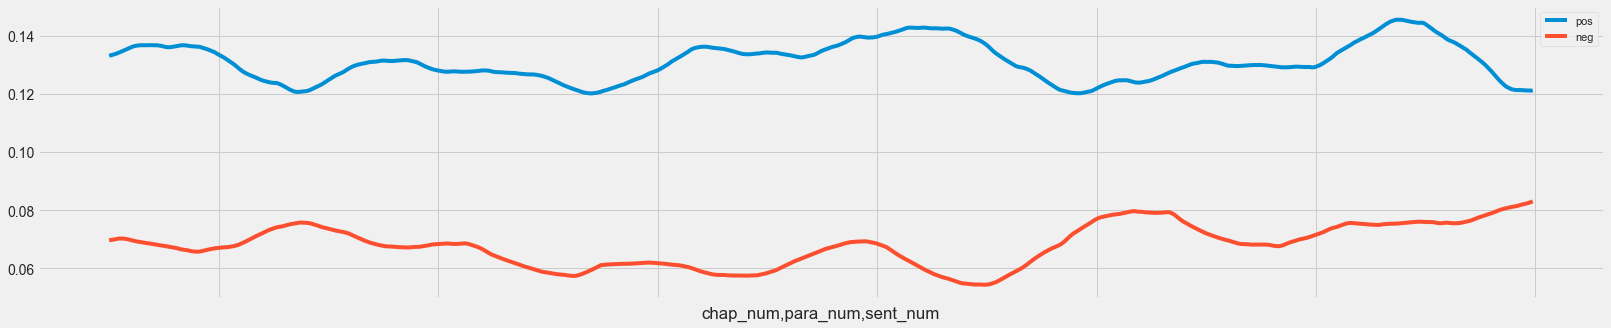

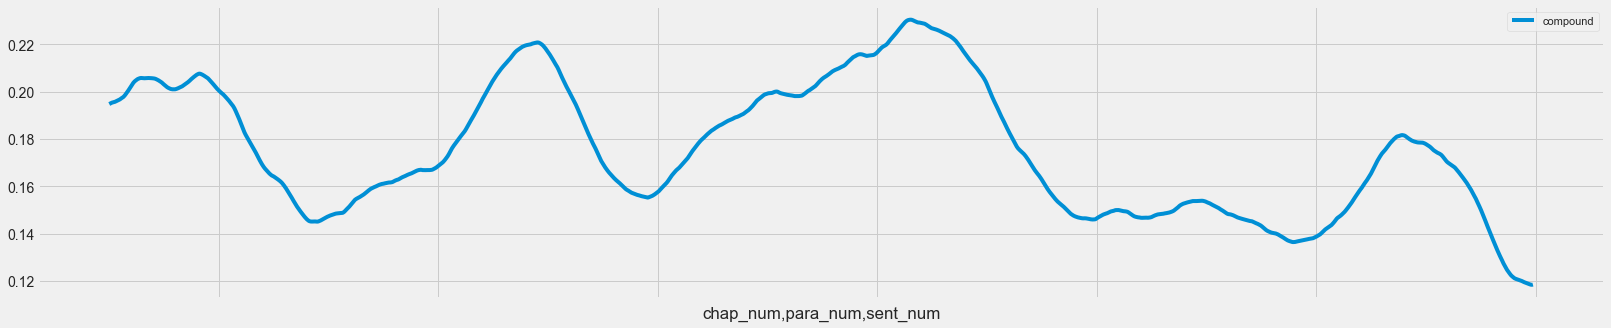

In [77]:
by_sent[['pos','neg']].rolling(**CFG1).mean().plot(**FIG)
by_sent[['compound']].rolling(**CFG1).mean().plot(**FIG)

## Compare KDE to Rolling Both Graphs of Syuzhet and VADER

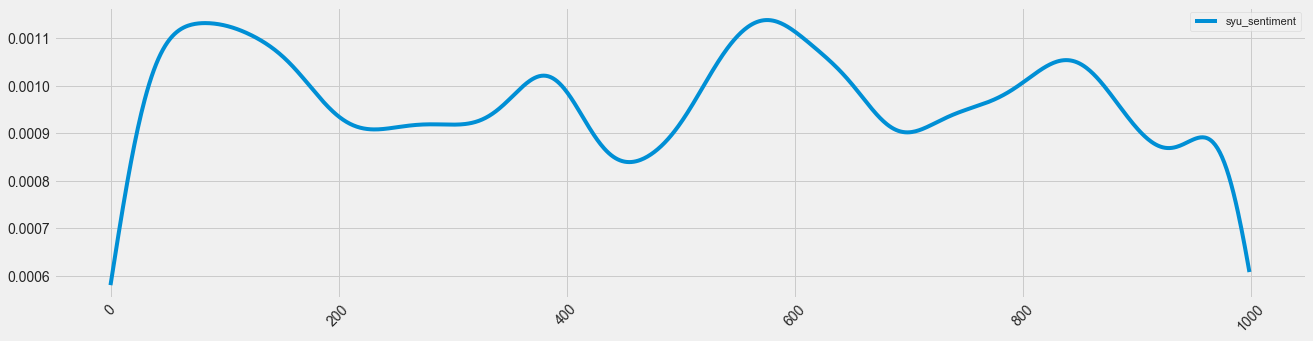

In [93]:
PLOTS[emo].plot(**FIG)

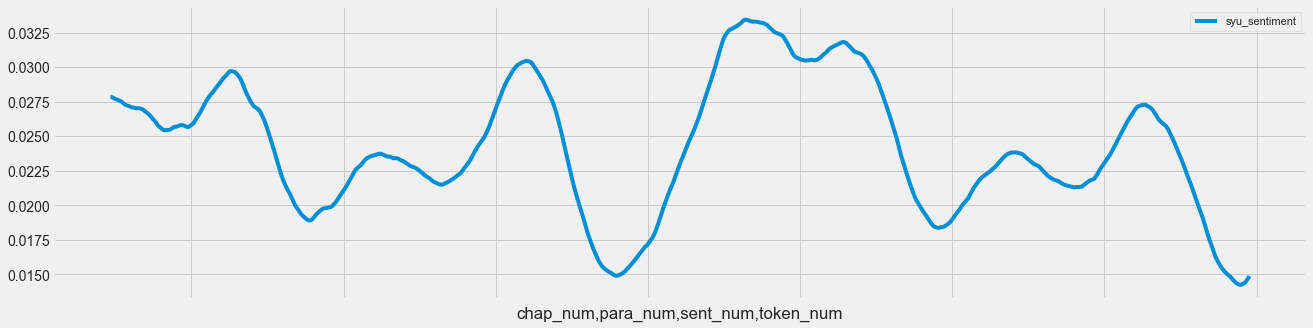

In [95]:
tokens[emo].fillna(0).rolling(**CFG2).mean().plot(**FIG)

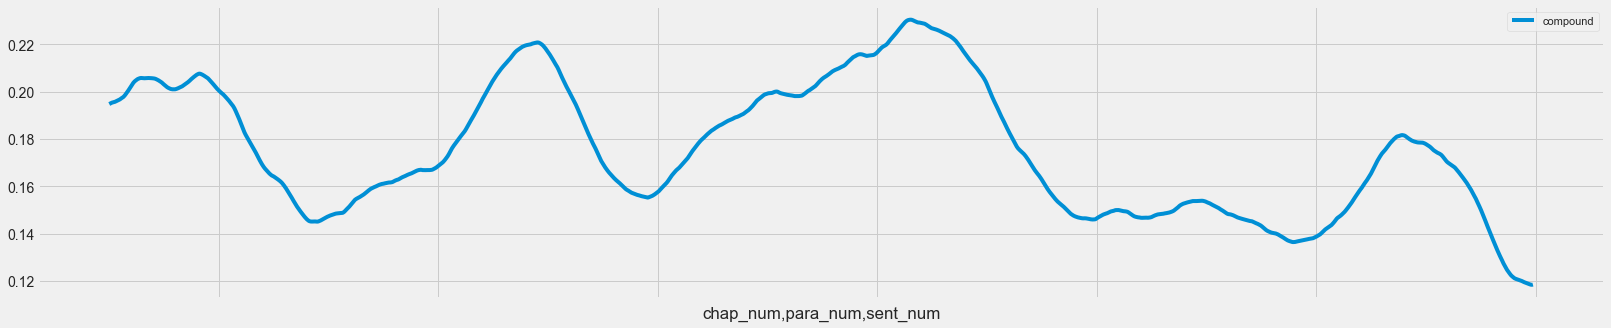

In [80]:
by_sent[['compound']].rolling(**CFG1).mean().plot(**FIG)

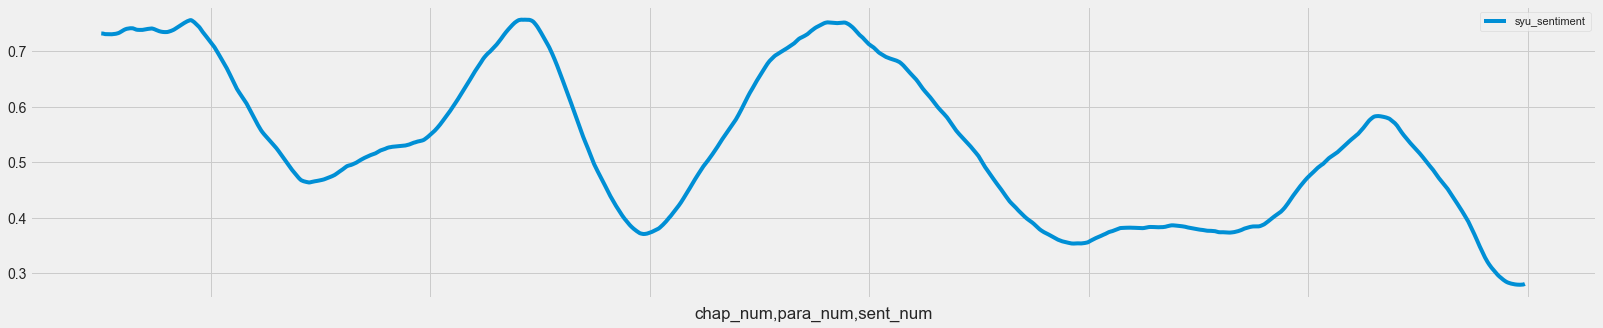

In [81]:
by_sent[emo].fillna(0).rolling(**CFG1).mean().plot(**FIG)

## Experimental Plotting Function

In [98]:
def  plot_sentiment(emo_col, type='sent'):
    if type == 'sent':
        by_sent[emo_col].fillna(0).rolling(**CFG1).mean().plot(**FIG)
    elif type == 'tokens':
        tokens[emo_col].fillna(0).rolling(**CFG2).mean().plot(**FIG)
    elif type == 'kde':
        PLOTS[emo_col].plot(**FIG)
    else:
        pass

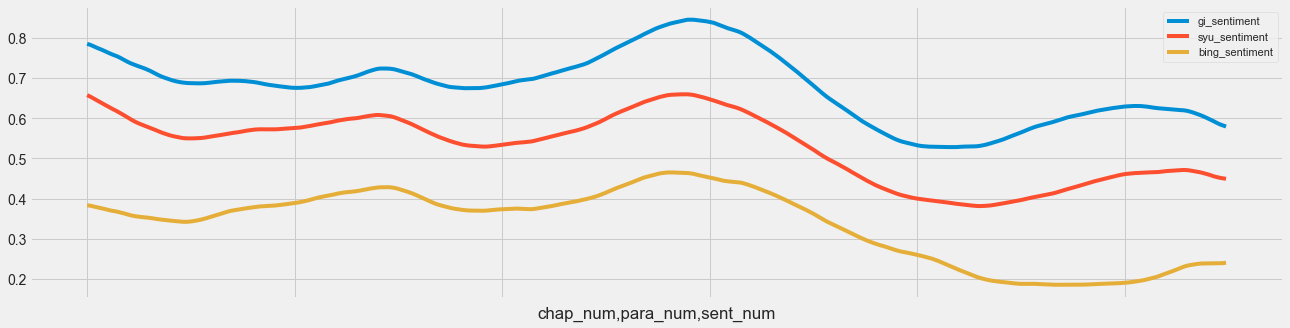

In [103]:
plot_sentiment('gi_sentiment')
plot_sentiment('syu_sentiment')
plot_sentiment('bing_sentiment')

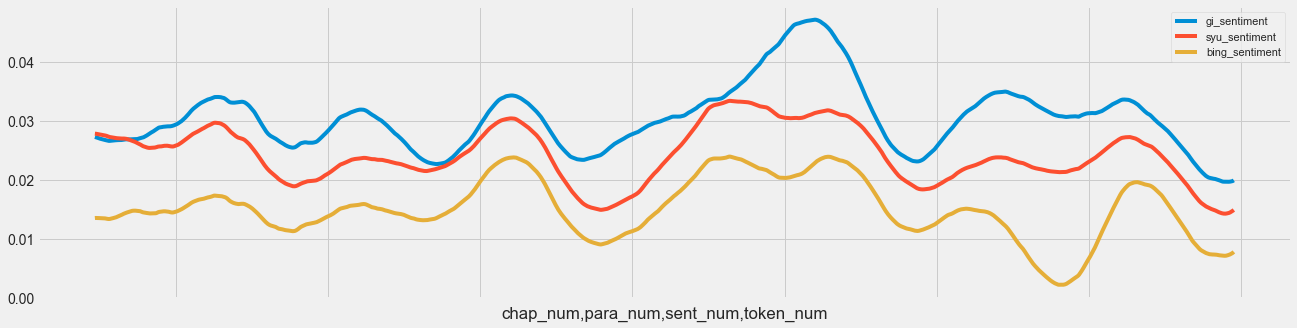

In [102]:
plot_sentiment('gi_sentiment', type='tokens')
plot_sentiment('syu_sentiment', type='tokens')
plot_sentiment('bing_sentiment', type='tokens')

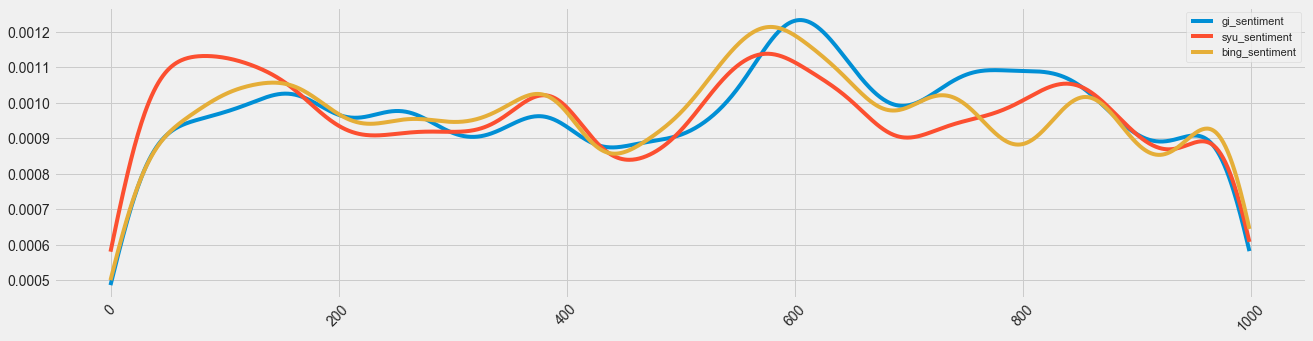

In [104]:
plot_sentiment('gi_sentiment', type='kde')
plot_sentiment('syu_sentiment', type='kde')
plot_sentiment('bing_sentiment', type='kde')